Loading processed data...

Running Apriori Algorithm...
Found 612 frequent itemsets.
Generating Association Rules...
Filtered down to 2084 specific Attack Detection Rules.

✅ Rules saved to: ../results/rules.csv

Top 5 Rules (by Lift):
          antecedents                   consequents   support  confidence  \
4815   [domain_u, SF]      [udp, Low, Zero, normal]  0.069506    0.962088   
4813  [domain_u, Low]       [udp, SF, Zero, normal]  0.069506    0.962088   
4822       [domain_u]  [Low, udp, SF, Zero, normal]  0.069506    0.962088   
1846       [domain_u]           [udp, Zero, normal]  0.069506    0.962088   
3556   [domain_u, SF]           [udp, Zero, normal]  0.069506    0.962088   

          lift  leverage  conviction  
4815  11.57446  0.063501   24.184328  
4813  11.57446  0.063501   24.184328  
4822  11.57446  0.063501   24.184328  
1846  11.57446  0.063501   24.184328  
3556  11.57446  0.063501   24.184328  
✅ Scatter plot saved to: ../results/plots/04_rules_scatter.png
Gene

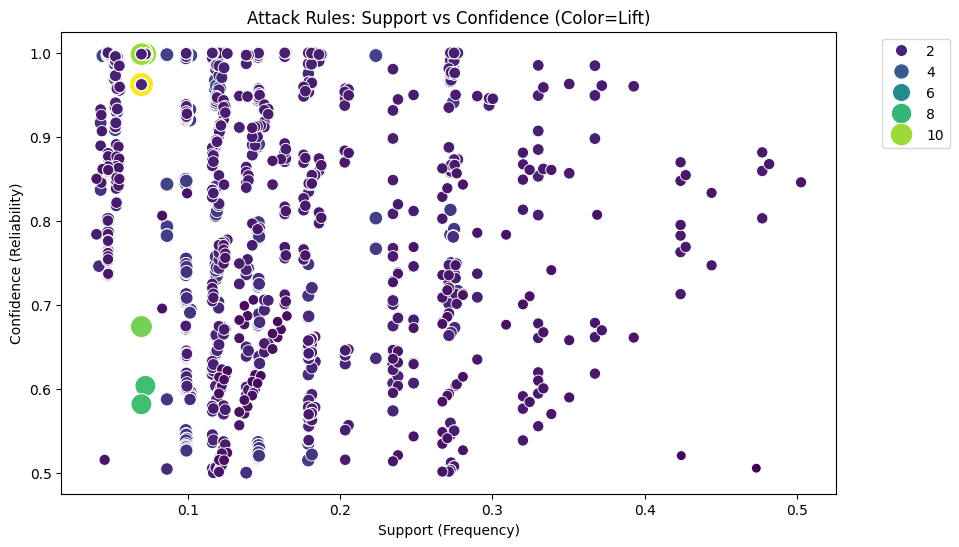

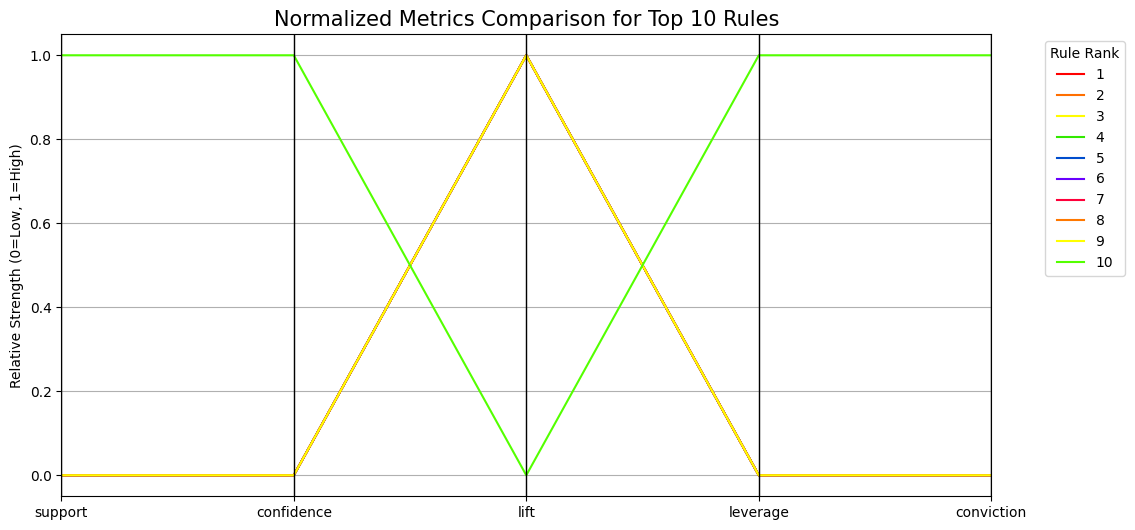

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from pandas.plotting import parallel_coordinates
import os
import numpy as np

# --- Configuration ---
INPUT_PATH = '../data/processed_data.csv'
RESULTS_PATH = '../results/rules.csv'
SCATTER_PLOT_PATH = '../results/plots/04_rules_scatter.png'
METRICS_PLOT_PATH = '../results/plots/05_rules_parallel.png'
COMPARISON_PATH = '../results/comparison_table.csv'

def run_mining():
    print("Loading processed data...")
    df = pd.read_csv(INPUT_PATH)
    
    # --- Step 1: Prepare Data for Apriori ---
    transactions = df.values.tolist()
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
    
    # --- Step 2: Main Mining Run ---
    print("\nRunning Apriori Algorithm...")
    # Using min_support=0.04 to catch slightly more attack patterns
    frequent_itemsets = apriori(df_encoded, min_support=0.04, use_colnames=True)
    print(f"Found {len(frequent_itemsets)} frequent itemsets.")

    # --- Step 3: Rule Generation (With ALL Metrics) ---
    print("Generating Association Rules...")
    # mlxtend calculates support, confidence, lift, leverage, and conviction by default
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
    
    # --- Step 4: Filtering for "Attack" Rules ---
    all_classes = df['Class'].unique()
    
    def is_attack_prediction(consequent_set):
        for item in consequent_set:
            if item in all_classes and item != 'Normal': 
                return True
        return False

    # Filter: Keep only rules that predict an ATTACK
    attack_rules = rules[rules['consequents'].apply(is_attack_prediction)].copy()
    
    # Clean up: Convert frozen sets to strings for readability in CSV
    attack_rules['antecedents'] = attack_rules['antecedents'].apply(lambda x: list(x))
    attack_rules['consequents'] = attack_rules['consequents'].apply(lambda x: list(x))
    
    # Sort by Lift (Strength)
    attack_rules = attack_rules.sort_values(by='lift', ascending=False)
    
    # Select specific columns for the final report
    final_cols = ['antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', 'conviction']
    attack_rules = attack_rules[final_cols]

    print(f"Filtered down to {len(attack_rules)} specific Attack Detection Rules.")
    
    if len(attack_rules) > 0:
        # Save to CSV
        attack_rules.to_csv(RESULTS_PATH, index=False)
        print(f"\n✅ Rules saved to: {RESULTS_PATH}")
        print("\nTop 5 Rules (by Lift):")
        print(attack_rules.head())

        # --- Step 5a: Scatter Plot (Support vs Confidence) ---
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x="support", y="confidence", size="lift", hue="lift", 
                        data=attack_rules, palette="viridis", sizes=(50, 300))
        plt.title('Attack Rules: Support vs Confidence (Color=Lift)')
        plt.xlabel('Support (Frequency)')
        plt.ylabel('Confidence (Reliability)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        if not os.path.exists('../results/plots'):
            os.makedirs('../results/plots')
        plt.savefig(SCATTER_PLOT_PATH, bbox_inches='tight')
        print(f"✅ Scatter plot saved to: {SCATTER_PLOT_PATH}")

        # --- Step 5b: Parallel Coordinates Metrics Plot ---
        # This visualizes how the top 10 rules perform across ALL 5 metrics
        print("Generating Metrics Visualization...")
        
        # Normalize data for visualization (so 0.9 confidence and 15.0 lift fit on same chart)
        top_rules = attack_rules.head(10).copy()
        top_rules['rule_id'] = range(1, len(top_rules) + 1) # Label rules 1-10
        
        # Select metrics to plot
        metrics_to_plot = ['support', 'confidence', 'lift', 'leverage', 'conviction']
        
        # Min-Max Normalization just for the plot
        df_norm = top_rules.copy()
        for metric in metrics_to_plot:
            min_val = df_norm[metric].min()
            max_val = df_norm[metric].max()
            if max_val - min_val > 0:
                df_norm[metric] = (df_norm[metric] - min_val) / (max_val - min_val)
            else:
                df_norm[metric] = 0.5 # Default if all values are same

        plt.figure(figsize=(12, 6))
        pd.plotting.parallel_coordinates(df_norm[['rule_id'] + metrics_to_plot], 'rule_id', colormap='prism')
        plt.title('Normalized Metrics Comparison for Top 10 Rules', fontsize=15)
        plt.ylabel('Relative Strength (0=Low, 1=High)')
        plt.legend(title="Rule Rank", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(METRICS_PLOT_PATH, bbox_inches='tight')
        print(f"✅ Metrics plot saved to: {METRICS_PLOT_PATH}")

    else:
        print("❌ No attack rules found. Try lowering min_support.")

    # --- Step 6: Parameter Sensitivity (Required for Report) ---
    print("\n--- Running Parameter Sensitivity Analysis ---")
    comparison_data = []
    scenarios = [
        {"min_sup": 0.02, "min_conf": 0.5},
        {"min_sup": 0.04, "min_conf": 0.6},
        {"min_sup": 0.06, "min_conf": 0.7}
    ]

    for s in scenarios:
        frequent = apriori(df_encoded, min_support=s["min_sup"], use_colnames=True)
        if len(frequent) > 0:
            rules_found = association_rules(frequent, metric="confidence", min_threshold=s["min_conf"])
            # Filter for attacks
            atk_found = rules_found[rules_found['consequents'].apply(is_attack_prediction)]
            count = len(atk_found)
        else:
            count = 0
            
        comparison_data.append({
            "Min Support": s["min_sup"], 
            "Min Confidence": s["min_conf"], 
            "Attack Rules Found": count
        })

    df_comp = pd.DataFrame(comparison_data)
    df_comp.to_csv(COMPARISON_PATH, index=False)
    print("\nComparison Table:")
    print(df_comp)
    print(f"\n✅ Comparison table saved to: {COMPARISON_PATH}")

if __name__ == "__main__":
    run_mining()